# FineST in NPC Visium data

## Main steps

- Step1: Prepare the paired image and expression
- Step2: Train and test the model within spot
- Step3: infer gene expression of between spot

In [1]:
import os
import time
import random
import warnings
warnings.filterwarnings('ignore')

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch. utils.data import DataLoader, Dataset, TensorDataset
from scipy.sparse import csr_matrix
from tqdm import tqdm
import scanpy as sc
import anndata  

import FineST as fst
from FineST.datasets import dataset
from FineST.utils import *        
from FineST.loadData import * 
from FineST.model import * 
from FineST.train import * 
from FineST.inference import * 
from FineST.evaluation import * 
from FineST.imputation import * 

print(h5py.__version__)
print(torch.__version__)
print("FineST version: %s" %fst.__version__)

3.10.0
1.7.1
FineST version: 0.0.1


In [2]:
path = '/mnt/lingyu/nfs_share2/Python/'
setup_seed(666)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

import matplotlib.colors as clr
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)

In [3]:
##############################################################
# make logging and save model
##############################################################
import logging
from datetime import datetime
logging.getLogger().setLevel(logging.INFO)

model_folder = str(path) + 'FineST/FineST/Finetune/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = setup_logger(dir_name)

print(dir_name)

/mnt/lingyu/nfs_share2/Python/FineST/FineST/Finetune/20241006221845787989


In [4]:
##############################################################
# load parameter settings
##############################################################

import json
parameter_file_path = str(path) + 'FineST/FineST/Parameter/parameters_NPC_P10125.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2024-10-06 22:18:45] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 64,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.1,
  "k_nearest_positives": 0,
  "temperature": 0.03
}


## 1. Load Spatial and Image data

1.1 Load spatial data

In [5]:
adata = dataset.NPC()
print(adata)

AnnData object with n_obs × n_vars = 1331 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


1.2 Selected LR genes 

In [6]:
def load_lr_genes(path):
    file_path = os.path.join(path, 'FineST/FineST/Dataset/LRgene/LRgene_CellChatDB_baseline.csv')
    LRgene = pd.read_csv(file_path)
    return LRgene['LR gene'].tolist()

def adata_LR(adata, gene_list):
    adata_matrix = pd.DataFrame(adata.X.A, index=adata.obs_names, columns=adata.var_names)
    available_genes = [gene for gene in gene_list if gene in adata_matrix.columns]
    adataLR_matrix = adata_matrix[available_genes]
    adata._n_vars = adataLR_matrix.shape[1]
    adata.X = adataLR_matrix.values
    adata.var = adata.var.loc[available_genes]
    adata.var_names = adataLR_matrix.columns
    return adata

In [7]:
## Load LR 963 genes and extract their gene expression
adata = adata_LR(adata, load_lr_genes(path))
adata

AnnData object with n_obs × n_vars = 1331 × 911
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

1.3 Data preprocess

In [8]:
def adata_preprocess(adata, min_cells=10, target_sum=None, n_top_genes=None): 
    adata.var_names_make_unique()

    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    if n_top_genes is not None:
        sc.pp.normalize_total(adata, target_sum=target_sum)
    else:
        sc.pp.normalize_total(adata)
        
    sc.pp.log1p(adata)
    
    if n_top_genes is not None:
        sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
        
    return adata

In [9]:
adata = adata_preprocess(adata)
print(adata)

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


In [10]:
gene_hv = np.array(adata.var_names)
print("gene_hv length:", len(gene_hv))

gene_hv length: 596


1.4 Reload adata with selected gene

In [11]:
## Access the matrix and convert it to a dense matrix
matrix = pd.DataFrame(adata.X)
matrix.columns = gene_hv
spotID = np.array(pd.DataFrame(adata.obs['in_tissue']).index)
matrix.insert(0, '', spotID)   
matrix = matrix.set_index(matrix.columns[0])
print(matrix.shape)
matrix

(1331, 596)


TGFB1    TGFBR1   TGFBR2  TGFB2     TGFB3    ACVR1B  \
                                                                             
AAACAATCTACTAGCA-1  0.000000  0.000000  0.00000    0.0  0.784856  0.784856   
AAACGAAGAACATACC-1  1.538792  0.000000  0.00000    0.0  0.000000  0.000000   
AAAGGGATGTAGCAAG-1  0.000000  0.481666  0.00000    0.0  0.000000  0.481666   
AAAGTCACTGATGTAA-1  0.000000  0.633767  0.00000    0.0  0.000000  1.018628   
AAAGTGTGATTTATCT-1  0.501523  0.000000  1.08306    0.0  0.000000  0.000000   
...                      ...       ...      ...    ...       ...       ...   
TTGTGGCCCTGACAGT-1  0.000000  0.000000  0.00000    0.0  0.000000  0.000000   
TTGTGTTTCCCGAAAG-1  0.890100  0.000000  0.00000    0.0  0.000000  0.000000   
TTGTTAGCAAATTCGA-1  0.457721  0.457721  0.00000    0.0  0.000000  0.457721   
TTGTTCAGTGTGCTAC-1  1.879867  0.000000  0.00000    0.0  0.000000  0.000000   
TTGTTTGTGTAAATTC-1  0.888100  0.000000  0.00000    0.0  0.000000  0.888100   

                    ACVR1C     ACVR1      BMP2  BMPR1A  ...  KDR     TREM2  \
                                                        ...                  
AAACAATCTACTAGCA-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.784856   
AAACGAAGAACATACC-1     0.0  0.797351  0.000000  0.0000  ...  0.0  0.000000   
AAAGGGATGTAGCAAG-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.000000   
AAAGTCACTGATGTAA-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.000000   
AAAGTGTGATTTATCT-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.000000   
...                    ...       ...       ...     ...  ...  ...       ...   
TTGTGGCCCTGACAGT-1     0.0  0.888100  0.000000  0.8881  ...  0.0  0.000000   
TTGTGTTTCCCGAAAG-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.000000   
TTGTTAGCAAATTCGA-1     0.0  0.457721  0.457721  0.0000  ...  0.0  0.000000   
TTGTTCAGTGTGCTAC-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.000000   
TTGTTTGTGTAAATTC-1     0.0  0.000000  0.000000  0.0000  ...  0.0  0.000000   

                      SEMA6A  SEMA6B    SEMA7A    PLXNC1   SIGLEC1      THY1  \
                                                                               
AAACAATCTACTAGCA-1  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
AAACGAAGAACATACC-1  0.797351     0.0  0.000000  0.000000  0.797351  0.000000   
AAAGGGATGTAGCAAG-1  0.000000     0.0  0.000000  0.000000  0.000000  0.481666   
AAAGTCACTGATGTAA-1  0.633767     0.0  0.000000  0.000000  0.633767  0.000000   
AAAGTGTGATTTATCT-1  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
...                      ...     ...       ...       ...       ...       ...   
TTGTGGCCCTGACAGT-1  0.000000     0.0  0.888100  0.000000  0.000000  0.000000   
TTGTGTTTCCCGAAAG-1  0.000000     0.0  0.540979  0.540979  0.000000  0.540979   
TTGTTAGCAAATTCGA-1  0.457721     0.0  0.000000  0.000000  0.000000  0.000000   
TTGTTCAGTGTGCTAC-1  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
TTGTTTGTGTAAATTC-1  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   

                       VCAM1      VSIR  
                                        
AAACAATCTACTAGCA-1  0.000000  0.000000  
AAACGAAGAACATACC-1  1.235270  0.000000  
AAAGGGATGTAGCAAG-1  1.409484  0.481666  
AAAGTCACTGATGTAA-1  1.512659  0.633767  
AAAGTGTGATTTATCT-1  0.501523  0.833982  
...                      ...       ...  
TTGTGGCCCTGACAGT-1  0.888100  0.888100  
TTGTGTTTCCCGAAAG-1  0.540979  0.890100  
TTGTTAGCAAATTCGA-1  1.500249  0.457721  
TTGTTCAGTGTGCTAC-1  2.493640  0.000000  
TTGTTTGTGTAAATTC-1  0.888100  1.350931  

[1331 rows x 596 columns]

1.5 Order by image file name

In [12]:
def get_data(file_paths, data_name):
    data = []
    file_paths.sort() 
    for file_path in file_paths:
        parts = file_path.split('_')
        if data_name == "BRCA":
            part_3 = int(parts[1])
            part_4 = int(parts[2].split('.')[0])
        elif data_name == "NPC":
            part_3 = int(parts[2])
            part_4 = int(parts[3].split('.')[0])
        else:
            print("Invalid data_name. Please use 'NPC' or 'BRCA'")
            return
        data.append([part_3, part_4])
    df = pd.DataFrame(data, columns=['pixel_y', 'pixel_x'])
    return df[['pixel_x', 'pixel_y']]

def merge_dfs(df, position):
    merged_df = pd.merge(df, position, on=['pixel_x', 'pixel_y'], how='left')
    cols = merged_df.columns.tolist()
    cols.remove('pixel_x')
    cols.remove('pixel_y')
    merged_df = merged_df[cols + ['pixel_x', 'pixel_y']]
    col_x = merged_df.columns[-4]
    col_y = merged_df.columns[-3]
    return merged_df.rename(columns={col_x: 'x', col_y: 'y'})

In [13]:
## Load image embedding from HIPT
os.chdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/')
file_paths = sorted(os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/'))
print("Image embedding file:", file_paths[:3])

df = get_data(file_paths, data_name="NPC")
print(df.shape)
print(df.head())

Image embedding file: ['AH_Patient1_10014_10023.pth', 'AH_Patient1_10015_9649.pth', 'AH_Patient1_10016_9276.pth']
(1331, 2)
   pixel_x  pixel_y
0    10023    10014
1     9649    10015
2     9276    10016
3     7783    10020
4     7410    10021


In [14]:
## position
os.chdir(str(path)+'FineST/FineST/Dataset/NPC/patient1/')
position = pd.read_csv('tissue_positions_list.csv', header=None)
position = position.rename(columns={position.columns[-2]: 'pixel_x', position.columns[-1]: 'pixel_y'})
print(position.shape)
print(position.head())

## merge position
position_image = merge_dfs(df, position)
spotID_order = np.array(position_image[0])
print(position_image.head())

(4992, 6)
                    0  1  2  3  pixel_x  pixel_y
0  ACGCCTGACACGCGCT-1  0  0  0     1416     1884
1  TACCGATCCAACACTT-1  0  1  1     1603     1991
2  ATTAAAGCGGACGAGC-1  0  0  2     1417     2098
3  GATAAGGGACGATTAG-1  0  1  3     1604     2205
4  GTGCAAATCACCAATA-1  0  0  4     1417     2313
                    0  1   x   y  pixel_x  pixel_y
0  GTCGTTATTCGCTTAT-1  1  46  76    10023    10014
1  ACAAGGGCAGGCTCTG-1  1  44  76     9649    10015
2  TGCGTTTGTTGACACT-1  1  42  76     9276    10016
3  TTGAATATGGACTTTC-1  1  34  76     7783    10020
4  CCGGGCGGTCTCGTCA-1  1  32  76     7410    10021


1.6 Order matrix low, spatial corr by image file name

In [15]:
def sort_matrix(matrix, position_image):
    position_image_first_col = position_image.columns[0]
    matrix = matrix.reset_index().rename(columns={matrix.index.name: position_image_first_col})
    sorted_matrix = pd.merge(position_image[[position_image_first_col]], matrix, on=position_image_first_col, how="left")
    matrix_order = np.array(sorted_matrix.set_index(position_image_first_col))
    return matrix_order

In [16]:
matrix_order = sort_matrix(matrix, position_image)
matrix_order_df = pd.DataFrame(matrix_order)
matrix_order_df.index = spotID_order
matrix_order_df.columns = gene_hv

In [17]:
## save gene expression mateix
# np.save(str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy', matrix_order_df.T)

In [18]:
def update_adata(adata, matrix_order, position_image):
    adata.X = csr_matrix(matrix_order, dtype=np.float32)
    adata.obsm['spatial'] = np.array(position_image.loc[:, ['pixel_y', 'pixel_x']])
    adata.obs['array_row'] = np.array(position_image.loc[:, 'y'])
    adata.obs['array_col'] = np.array(position_image.loc[:, 'x'])
    return adata

In [19]:
adata = update_adata(adata, matrix_order, position_image)
print(adata)

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'


In [20]:
## save the original adata
# patientxy = 'patient1'
# adata.write_h5ad(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_orignal.h5ad')

In [21]:
########################################
# save image position: only run once
########################################
position_order = pd.DataFrame({
    "pixel_y": position_image.loc[:, 'pixel_y'],
    "pixel_x": position_image.loc[:, 'pixel_x'],
    "array_row": position_image.loc[:, 'y'],
    "array_col": position_image.loc[:, 'x']
})
print(position_order)

      pixel_y  pixel_x  array_row  array_col
0       10014    10023         76         46
1       10015     9649         76         44
2       10016     9276         76         42
3       10020     7783         76         34
4       10021     7410         76         32
...       ...      ...        ...        ...
1326     9922     4237         75         15
1327     9923     3490         75         11
1328     9924     3117         75          9
1329     9925     2743         75          7
1330     9927     1997         75          3

[1331 rows x 4 columns]


In [22]:
## save the position data
# position_order.to_csv(str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order.csv', index=False, header=False)

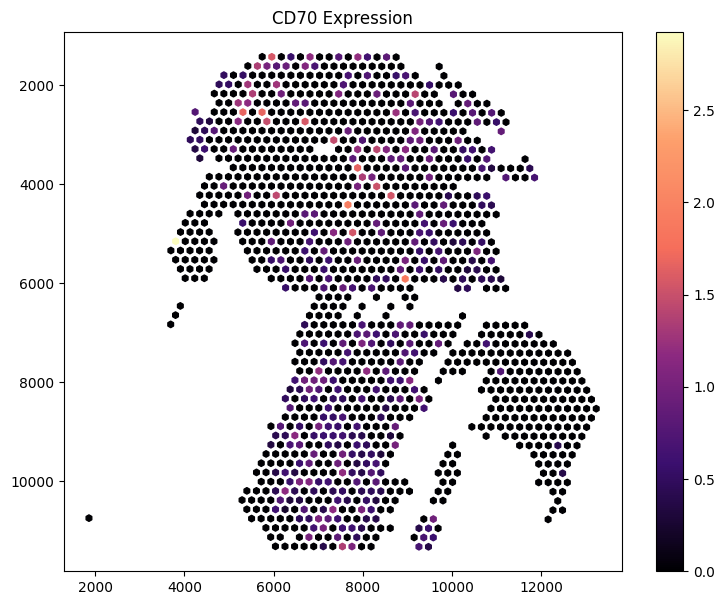

In [23]:
gene_selet = 'CD70'
fig, ax1 = plt.subplots(1, 1, figsize=(9, 7))
spatial_loc = adata.obsm['spatial']
scatter_plot = ax1.scatter(adata.obsm['spatial'][:, 0],adata.obsm['spatial'][:, 1], 
                           c=matrix_order_df[gene_selet], cmap=cnt_color, marker='h', s=22) 
ax1.invert_yaxis()
ax1.set_title(str(gene_selet)+' Expression')
fig.colorbar(scatter_plot, ax=ax1)
plt.gcf().set_dpi(100)
plt.show()

## 2 Train and Test model

2.1 Data loader and splitting

In [24]:
def build_loaders(batch_size, image_embed_path):
    
    setup_seed(666)
    
    print("***** Building loaders *****")
    import glob
    image_paths = glob.glob(str(image_embed_path))
    image_paths.sort()
    
    dataset = DatasetCreat(
        image_paths=image_paths,
        spatial_pos_path=str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order.csv',
        reduced_mtx_path=str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy',     
    )

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    print("train/test split completed")
    print(len(train_dataset), len(test_dataset))

    ## Set up distributed sampler
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
    
    print("***** Finished building loaders *****")
    return train_loader, test_loader

In [25]:
image_embed_path_NPC=str(path)+'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth'
print(image_embed_path_NPC)

/mnt/lingyu/nfs_share2/Python/NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth


In [26]:
## split training data and test data 
train_loader, test_loader = build_loaders(batch_size=params['batch_size'], image_embed_path=image_embed_path_NPC)

***** Building loaders *****
Finished loading all files
train/test split completed
1064 267
***** Finished building loaders *****


In [27]:
def build_loaders_inference(batch_size, image_embed_path):

    setup_seed(666)
    
    print("***** Building loaders_inference *****")
    import glob
    image_paths = glob.glob(str(image_embed_path))
    image_paths.sort()
    
    dataset = DatasetCreat(
        image_paths=image_paths,
        spatial_pos_path=str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order.csv',
        reduced_mtx_path=str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/harmony_matrix.npy',
    )
    
    all_dataset = DataLoader(dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
    print("***** Finished building loaders_inference *****")
    return all_dataset

In [28]:
all_dataset = build_loaders_inference(batch_size=adata.shape[0], image_embed_path=image_embed_path_NPC)
input_spot_all, input_image_all, input_coord_all, input_row_all, input_col_all = extract_test_data(all_dataset)
print("input_spot_all:", input_spot_all.shape)
print("input_image_all:", input_image_all.shape)
# print(input_image_all)
# print(input_spot_all)

***** Building loaders_inference *****
Finished loading all files
***** Finished building loaders_inference *****


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

***** batch_size=adata.shape[0] 不影响 *****
torch.Size([1331, 596])
torch.Size([1331, 16, 384])
1
1
1
***** *****
Finished extractting test data
input_spot_all: torch.Size([1331, 596])
input_image_all: torch.Size([1331, 16, 384])


In [29]:
input_spot_test, input_image_test, input_coord_test, input_row_test, input_col_test = extract_test_data(test_loader)
print("input_spot_test:", input_spot_test.shape)
print("input_image_test:", input_image_test.shape)
# print(input_image_test)
# print(input_spot_test)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 46.50it/s]

***** batch_size=adata.shape[0] 不影响 *****
torch.Size([200, 596])
torch.Size([200, 16, 384])
1
1
1
***** *****
Finished extractting test data
input_spot_test: torch.Size([200, 596])
input_image_test: torch.Size([200, 16, 384])


2.2 Train and test model on within spot

In [35]:
### load parameter settings
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

## add params
params['n_input_matrix'] = len(gene_hv)
params['n_input_image'] = 384

## init the model
model = CellContrastModel(n_input_matrix=params['n_input_matrix'],
                          n_input_image=params['n_input_image'],
                          n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
                          n_encoder_hidden_image=params["n_encoder_hidden_image"],
                          n_encoder_latent=params["n_encoder_latent"],
                          n_projection_hidden=params["n_projection_hidden"],
                          n_projection_output=params["n_projection_output"],
                          n_encoder_layers=params["n_encoder_layers"]).to(device) 
l = ContrastiveLoss(temperature=params['temperature'])
# print(model)

## Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], momentum=0.9, weight_decay=5e-4)

## Load the data
train_loader, test_loader = build_loaders(batch_size=params['batch_size'], image_embed_path=image_embed_path_NPC)


# Train the model for a fixed number of epoch
logger.info('Begin Training ...')

start_time = time.time()

best_loss = float('inf')
best_epoch = 0
for epoch in range(params['training_epoch']):
    logger.info('epoch [{}/{}]'.format(epoch + 1, epoch))
    print(f"Epoch: {epoch + 1}")
    
    ######################################################################################
    # Train the model 
    ######################################################################################
    model.train()
    train_loss = train_model(params, model, train_loader, optimizer, epoch, l)    # LOSS
    
    ######################################################################################
    # Evaluate the model 
    ######################################################################################
    model.eval()
    with torch.no_grad():
        test_loss = test_model(params, model, test_loader, l)
    
    if best_loss > test_loss:
        best_loss = test_loss
        best_epoch = epoch

        save_model(model, dir_name, params, optimizer, train_loss)
        # torch.save(model.state_dict(), "STFinetune/best.pt")    # BLEEP
        print("Saved Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))
        logger.info("Saved Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))

print("Done!, final loss: {}".format(best_loss))
print("Best epoch: {}".format(best_epoch))

print("--- %s seconds ---" % (time.time() - start_time))

logger.info("Done!, Best epoch & Best Model! Loss: [{}: {}]".format(best_epoch, best_loss))

logger.info('Finished Training')


***** Building loaders *****


[2024-10-05 23:55:22] INFO - Begin Training ...
[2024-10-05 23:55:22] INFO - epoch [1/0]


Finished loading all files
train/test split completed
1064 267
***** Finished building loaders *****
Epoch: 1
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 50.51it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.97it/s]
[2024-10-05 23:55:24] INFO - Saved Best epoch & Best Model! Loss: [0: 6.591538747151692]
[2024-10-05 23:55:24] INFO - epoch [2/1]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [0: 6.591538747151692]
Epoch: 2
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.99it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.77it/s]
[2024-10-05 23:55:25] INFO - Saved Best epoch & Best Model! Loss: [1: 6.504086256027222]
[2024-10-05 23:55:25] INFO - epoch [3/2]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [1: 6.504086256027222]
Epoch: 3
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.40it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.40it/s]
[2024-10-05 23:55:25] INFO - Saved Best epoch & Best Model! Loss: [2: 6.33589752515157]
[2024-10-05 23:55:25] INFO - epoch [4/3]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [2: 6.33589752515157]
Epoch: 4
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.87it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.20it/s]
[2024-10-05 23:55:26] INFO - Saved Best epoch & Best Model! Loss: [3: 6.244754155476888]
[2024-10-05 23:55:26] INFO - epoch [5/4]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [3: 6.244754155476888]
Epoch: 5
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.01it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.85it/s]
[2024-10-05 23:55:26] INFO - Saved Best epoch & Best Model! Loss: [4: 6.193502108256022]
[2024-10-05 23:55:26] INFO - epoch [6/5]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [4: 6.193502108256022]
Epoch: 6
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.60it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.53it/s]
[2024-10-05 23:55:27] INFO - Saved Best epoch & Best Model! Loss: [5: 6.150462706883748]
[2024-10-05 23:55:27] INFO - epoch [7/6]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [5: 6.150462706883748]
Epoch: 7
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.78it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.47it/s]
[2024-10-05 23:55:28] INFO - Saved Best epoch & Best Model! Loss: [6: 6.140520334243774]
[2024-10-05 23:55:28] INFO - epoch [8/7]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [6: 6.140520334243774]
Epoch: 8
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.56it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.93it/s]
[2024-10-05 23:55:28] INFO - Saved Best epoch & Best Model! Loss: [7: 6.108221610387166]
[2024-10-05 23:55:28] INFO - epoch [9/8]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [7: 6.108221610387166]
Epoch: 9
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.35it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.88it/s]
[2024-10-05 23:55:29] INFO - Saved Best epoch & Best Model! Loss: [8: 6.071570634841919]
[2024-10-05 23:55:29] INFO - epoch [10/9]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [8: 6.071570634841919]
Epoch: 10
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.95it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.50it/s]
[2024-10-05 23:55:29] INFO - Saved Best epoch & Best Model! Loss: [9: 6.054988463719686]
[2024-10-05 23:55:29] INFO - epoch [11/10]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [9: 6.054988463719686]
Epoch: 11
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 68.70it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.27it/s]
[2024-10-05 23:55:30] INFO - Saved Best epoch & Best Model! Loss: [10: 6.018951654434204]
[2024-10-05 23:55:30] INFO - epoch [12/11]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [10: 6.018951654434204]
Epoch: 12
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.92it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.22it/s]
[2024-10-05 23:55:30] INFO - epoch [13/12]


checkNeighbors.............
Epoch: 13
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.07it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.59it/s]
[2024-10-05 23:55:31] INFO - Saved Best epoch & Best Model! Loss: [12: 5.94696323076884]
[2024-10-05 23:55:31] INFO - epoch [14/13]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [12: 5.94696323076884]
Epoch: 14
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.14it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.39it/s]
[2024-10-05 23:55:31] INFO - epoch [15/14]


checkNeighbors.............
Epoch: 15
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.57it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.52it/s]
[2024-10-05 23:55:32] INFO - Saved Best epoch & Best Model! Loss: [14: 5.918400287628174]
[2024-10-05 23:55:32] INFO - epoch [16/15]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [14: 5.918400287628174]
Epoch: 16
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.87it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.22it/s]
[2024-10-05 23:55:32] INFO - Saved Best epoch & Best Model! Loss: [15: 5.912964661916097]
[2024-10-05 23:55:32] INFO - epoch [17/16]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [15: 5.912964661916097]
Epoch: 17
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.49it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.95it/s]
[2024-10-05 23:55:33] INFO - Saved Best epoch & Best Model! Loss: [16: 5.906679630279541]
[2024-10-05 23:55:33] INFO - epoch [18/17]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [16: 5.906679630279541]
Epoch: 18
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.55it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.80it/s]
[2024-10-05 23:55:33] INFO - Saved Best epoch & Best Model! Loss: [17: 5.902221043904622]
[2024-10-05 23:55:33] INFO - epoch [19/18]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [17: 5.902221043904622]
Epoch: 19
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.15it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.10it/s]
[2024-10-05 23:55:34] INFO - Saved Best epoch & Best Model! Loss: [18: 5.862451791763306]
[2024-10-05 23:55:34] INFO - epoch [20/19]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [18: 5.862451791763306]
Epoch: 20
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.33it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.24it/s]
[2024-10-05 23:55:34] INFO - Saved Best epoch & Best Model! Loss: [19: 5.858784993489583]
[2024-10-05 23:55:34] INFO - epoch [21/20]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [19: 5.858784993489583]
Epoch: 21
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.82it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.80it/s]
[2024-10-05 23:55:35] INFO - Saved Best epoch & Best Model! Loss: [20: 5.832344849904378]
[2024-10-05 23:55:35] INFO - epoch [22/21]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [20: 5.832344849904378]
Epoch: 22
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 60.97it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.30it/s]
[2024-10-05 23:55:36] INFO - Saved Best epoch & Best Model! Loss: [21: 5.823706309000651]
[2024-10-05 23:55:36] INFO - epoch [23/22]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [21: 5.823706309000651]
Epoch: 23
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.30it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 72.41it/s]
[2024-10-05 23:55:36] INFO - epoch [24/23]


checkNeighbors.............
Epoch: 24
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.39it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.14it/s]
[2024-10-05 23:55:37] INFO - epoch [25/24]


checkNeighbors.............
Epoch: 25
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.47it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.49it/s]
[2024-10-05 23:55:37] INFO - epoch [26/25]


checkNeighbors.............
Epoch: 26
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.35it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.87it/s]
[2024-10-05 23:55:38] INFO - Saved Best epoch & Best Model! Loss: [25: 5.815057992935181]
[2024-10-05 23:55:38] INFO - epoch [27/26]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [25: 5.815057992935181]
Epoch: 27
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.89it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.52it/s]
[2024-10-05 23:55:38] INFO - Saved Best epoch & Best Model! Loss: [26: 5.779847939809163]
[2024-10-05 23:55:38] INFO - epoch [28/27]


checkNeighbors.............
Saved Best epoch & Best Model! Loss: [26: 5.779847939809163]
Epoch: 28
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.56it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.27it/s]
[2024-10-05 23:55:39] INFO - epoch [29/28]


checkNeighbors.............
Epoch: 29
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 55.42it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.78it/s]
[2024-10-05 23:55:40] INFO - epoch [30/29]


checkNeighbors.............
Epoch: 30
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.64it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.82it/s]
[2024-10-05 23:55:40] INFO - epoch [31/30]


checkNeighbors.............
Epoch: 31
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.19it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.09it/s]
[2024-10-05 23:55:41] INFO - epoch [32/31]


checkNeighbors.............
Epoch: 32
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 59.72it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.26it/s]
[2024-10-05 23:55:41] INFO - epoch [33/32]


checkNeighbors.............
Epoch: 33
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.79it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]
[2024-10-05 23:55:42] INFO - epoch [34/33]


checkNeighbors.............
Epoch: 34
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.07it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.48it/s]
[2024-10-05 23:55:42] INFO - epoch [35/34]


checkNeighbors.............
Epoch: 35
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.24it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.16it/s]
[2024-10-05 23:55:43] INFO - epoch [36/35]


checkNeighbors.............
Epoch: 36
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.68it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.51it/s]
[2024-10-05 23:55:44] INFO - epoch [37/36]


checkNeighbors.............
Epoch: 37
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.71it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.34it/s]
[2024-10-05 23:55:44] INFO - epoch [38/37]


checkNeighbors.............
Epoch: 38
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.63it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.12it/s]
[2024-10-05 23:55:45] INFO - epoch [39/38]


checkNeighbors.............
Epoch: 39
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.66it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.22it/s]
[2024-10-05 23:55:45] INFO - epoch [40/39]


checkNeighbors.............
Epoch: 40
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.65it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.13it/s]
[2024-10-05 23:55:46] INFO - epoch [41/40]


checkNeighbors.............
Epoch: 41
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.29it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.15it/s]
[2024-10-05 23:55:46] INFO - epoch [42/41]


checkNeighbors.............
Epoch: 42
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.80it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.25it/s]
[2024-10-05 23:55:47] INFO - epoch [43/42]


checkNeighbors.............
Epoch: 43
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 59.42it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.60it/s]
[2024-10-05 23:55:47] INFO - epoch [44/43]


checkNeighbors.............
Epoch: 44
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 59.51it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.09it/s]
[2024-10-05 23:55:48] INFO - epoch [45/44]


checkNeighbors.............
Epoch: 45
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.89it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 48.30it/s]
[2024-10-05 23:55:48] INFO - epoch [46/45]


checkNeighbors.............
Epoch: 46
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 60.45it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.66it/s]
[2024-10-05 23:55:49] INFO - epoch [47/46]


checkNeighbors.............
Epoch: 47
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.16it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.59it/s]
[2024-10-05 23:55:49] INFO - epoch [48/47]


checkNeighbors.............
Epoch: 48
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.88it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.47it/s]
[2024-10-05 23:55:50] INFO - epoch [49/48]


checkNeighbors.............
Epoch: 49
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.49it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.23it/s]
[2024-10-05 23:55:51] INFO - epoch [50/49]


checkNeighbors.............
Epoch: 50
train model


100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 56.85it/s]

checkNeighbors.............


test model


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.40it/s]
[2024-10-05 23:55:51] INFO - Done!, Best epoch & Best Model! Loss: [26: 5.779847939809163]
[2024-10-05 23:55:51] INFO - Finished Training


checkNeighbors.............
Done!, final loss: 5.779847939809163
Best epoch: 26


## 3. Inference, Imputation and Evaluation on within spot

3.1 Inference: within spot

In [30]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST/Finetune/20241006221845787989'

In [31]:
## You can use the 'dir_name' just obtained from the above
## but here we use the trained 'dir_name' before, for paper results repeated

dir_name = str(path)+'FineST/FineST/Finetune/20240125140443830148'  
parameter_file_path = str(path)+'FineST/FineST/Parameter/parameters_NPC_P10125.json'

In [32]:
#####################################################################################  
# main
#####################################################################################

# load params
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

# load models
model = load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)
# print("model", model)

# load all data
test_loader = build_loaders_inference(batch_size=adata.shape[0], image_embed_path=image_embed_path_NPC)


# inference
logger.info("Running inference tesk...")

start_time = time.time()

(matrix_profile, 
reconstructed_matrix, 
recon_ref_adata_image_f2, 
representation_image_reshape,
representation_matrix,
projection_image_reshape,
projection_matrix,
input_image_exp,
reconstruction_iamge,
reconstructed_matrix_reshaped,
input_coord_all) = perform_inference(model, test_loader)

print("--- %s seconds ---" % (time.time() - start_time))

# print
print(matrix_profile.shape)
print(reconstructed_matrix.shape)
print(recon_ref_adata_image_f2.shape)
# print("print(reconstructed_matrix_reshaped.shape)", reconstructed_matrix_reshaped.shape)
# print(matrix_profile)
# print(reconstructed_matrix)
# print(recon_ref_adata_image_f2)
# print(input_coord_all)

logger.info("Running inference tesk DONE!")

***** Building loaders_inference *****


[2024-10-06 22:18:53] INFO - Running inference tesk...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]

***** batch_size=adata.shape[0] 不影响 *****
torch.Size([1331, 596])
torch.Size([1331, 16, 384])
1
1
1
***** *****
Finished extractting test data



[2024-10-06 22:18:54] INFO - Running inference tesk DONE!


--- 0.9351062774658203 seconds ---
(1331, 596)
(1331, 596)
(1331, 596)


3.2 Inference: All subspot location

3.2.1 All subspot location

In [33]:
print(reconstructed_matrix_reshaped.shape)
print(reconstructed_matrix_reshaped.shape[0]/16)
reconstructed_matrix_reshaped_tensor, _ = reshape_latent_image(reconstructed_matrix_reshaped)

print(reconstructed_matrix_reshaped_tensor.shape)
print(reconstructed_matrix_reshaped_tensor[0, :, :].shape)
print(reconstructed_matrix_reshaped_tensor[:, :, 0].flatten().shape)

torch.Size([21296, 596])
1331.0
torch.Size([1331, 16, 596])
torch.Size([16, 596])
torch.Size([21296])


In [35]:
p = 0
x = spatial_loc[p][0]
y = spatial_loc[p][1]
print(x,y)


NN = reconstructed_matrix_reshaped_tensor.shape[1]
N = int(np.sqrt(NN))
p = 0
x = spatial_loc[p][0]
y = spatial_loc[p][1]


# 初始化为整数类型的零矩阵
C = np.zeros((N**2, 2), dtype=int)

for k in range(1, N**2 + 1):
    s = k % N

    if s == 0:
        i = N
        j = k // N
    else:
        i = s
        j = (k - i) // N + 1

    ## 64-16
    # C[k - 1, 0] = x - 7 - 7 * 14 + (i - 1) * 14
    # C[k - 1, 1] = y - 7 - 7 * 14 + (j - 1) * 14
    ## 64-4  -- h=64/4=16 --  x-(h/2)-(4/2-1)*h
    C[k - 1, 0] = x - 8 - 1 * 16 + (i - 1) * 16
    C[k - 1, 1] = y - 8 - 1 * 16 + (j - 1) * 16

print(C.shape)

10014 10023
(16, 2)


(16,)
torch.Size([1331, 16, 596])
tensor([1.3180, 1.3304, 1.3267, 1.2359, 1.2725, 1.2739, 1.2568, 1.2821, 1.2193,
        1.2283, 1.2269, 1.3081, 1.3408, 1.2965, 1.1944, 1.2097],
       device='cuda:0', grad_fn=<SelectBackward>)


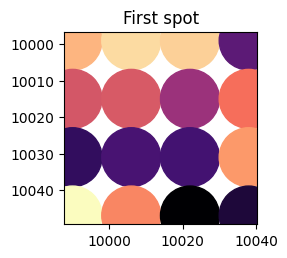

In [36]:
# Select the information of the first spot and the first variable
first_spot_first_variable = reconstructed_matrix_reshaped_tensor[0, :, 0].cpu().detach().numpy()
print(first_spot_first_variable.shape)
print(reconstructed_matrix_reshaped_tensor.shape)
print(reconstructed_matrix_reshaped_tensor[0, :, 0])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
scatter3 = ax.scatter(C[:, 0], C[:, 1], c=first_spot_first_variable, cmap=cnt_color, s=1800)
ax.invert_yaxis()
ax.set_title("First spot")
plt.show()

In [37]:
NN = reconstructed_matrix_reshaped_tensor.shape[1]
N = int(np.sqrt(NN))

# Initialize variables all_spot_all_variable and C2
all_spot_all_variable = np.zeros((reconstructed_matrix_reshaped_tensor.shape[0]*reconstructed_matrix_reshaped_tensor.shape[1], reconstructed_matrix_reshaped_tensor.shape[2]))
C2 = np.zeros((reconstructed_matrix_reshaped_tensor.shape[0] * reconstructed_matrix_reshaped_tensor.shape[1], 2), dtype=int)

## get the sub spot coord
for p in range(reconstructed_matrix_reshaped_tensor.shape[0]):
    # Calculate the coordinates of the 256 positions of the pth spot
    x = spatial_loc[p][0]
    y = spatial_loc[p][1]

    C = np.zeros((N**2, 2), dtype=int)

    for k in range(1, N**2 + 1):
        s = k % N

        if s == 0:
            i = N
            j = k // N
        else:
            i = s
            j = (k - i) // N + 1

        ## 224
        # C[k - 1, 0] = x - 7 - 7 * 14 + (i - 1) * 14
        # C[k - 1, 1] = y - 7 - 7 * 14 + (j - 1) * 14
        ## 64  -- h=64/4=16 --  x-(h/2) - (4/2-1)*h
        C[k - 1, 0] = x - 8 - 1 * 16 + (i - 1) * 16
        C[k - 1, 1] = y - 8 - 1 * 16 + (j - 1) * 16

    # Add the coordinates of the 16 positions of the pth spot to C2
    C2[p * 16:(p + 1) * 16, :] = C
print(C2.shape)

## get the sub-spot gene expression
for q in range(reconstructed_matrix_reshaped_tensor.shape[2]):
    # Extract the information of the first variable of the pth spot
    all_spot_all_variable[:, q] = reconstructed_matrix_reshaped_tensor[:, :, q].flatten().cpu().detach().numpy()    # the first variable
print(all_spot_all_variable.shape)

(21296, 2)
(21296, 596)


In [38]:
# Establish new anndata in sub spot level
data = pd.DataFrame(all_spot_all_variable)
adata_spot = sc.AnnData(X=data)
adata_spot.var_names = gene_hv
adata_spot.obs["x"] = C2[:, 0]
adata_spot.obs["y"] = C2[:, 1]
print(adata_spot)
print(adata_spot.obs["x"])
print(adata_spot.var_names)

AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
0         9990
1        10006
2        10022
3        10038
4         9990
         ...  
21291     9951
21292     9903
21293     9919
21294     9935
21295     9951
Name: x, Length: 21296, dtype: int64
Index(['TGFB1', 'TGFBR1', 'TGFBR2', 'TGFB2', 'TGFB3', 'ACVR1B', 'ACVR1C',
       'ACVR1', 'BMP2', 'BMPR1A',
       ...
       'KDR', 'TREM2', 'SEMA6A', 'SEMA6B', 'SEMA7A', 'PLXNC1', 'SIGLEC1',
       'THY1', 'VCAM1', 'VSIR'],
      dtype='object', length=596)


3.2.2 Neighbours of all within spot

In [39]:
def prepare_adata(adata, adata_spot, C2, gene_hv):
    # adata_know: adata (original) 1331 × 596
    # adata_spot: all subspot 21296 × 596
    adata_know = adata.copy()
    adata_know.obs["x"]=adata.obsm['spatial'][:,0]
    adata_know.obs["y"]=adata.obsm['spatial'][:,1]

    x_sudo, y_sudo = adata_spot.obs["x"].values, adata_spot.obs["y"].values
    x_know, y_know = adata_know.obs["x"].values, adata_know.obs["y"].values
    print("X_sudo & x_know:", x_sudo.shape, x_know.shape)    # X_sudo & x_know: (17424,) (adata.shape[0],)

    adata_spot.obsm['spatial'] = np.stack([adata_spot.obs["x"], adata_spot.obs["y"]]).T

    xlist = C2[:, 0].tolist()
    ylist = C2[:, 1].tolist()
    sudo = pd.DataFrame({"x": xlist, "y": ylist})  

    sudo_adata = anndata.AnnData(np.zeros((sudo.shape[0], len(gene_hv))))
    sudo_adata.obs = sudo
    sudo_adata.var = adata_know.var
    
    return adata_know, sudo_adata, adata_spot

In [40]:
adata_know, sudo_adata, adata_spot = prepare_adata(adata, adata_spot, C2, gene_hv)
print(adata_know)
print(sudo_adata)

X_sudo & x_know: (21296,) (1331,)
AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [41]:
start_time = time.time()

nearest_points = find_nearest_point(adata_spot.obsm['spatial'], adata_know.obsm['spatial'])    
nbs, nbs_indices = find_nearest_neighbors(nearest_points, adata_know.obsm['spatial'])
distances = calculate_euclidean_distances(adata_spot.obsm['spatial'], nbs)

# Iterate over each point in sudo_adata
for i in range(sudo_adata.shape[0]):
    dis_tmp = (distances[i] + 0.1) / np.min(distances[i] + 0.1)
    k = 1
    weights = ((1 / (dis_tmp ** k)) / ((1 / (dis_tmp ** k)).sum()))
    sudo_adata.X[i, :] = np.dot(weights, adata_know.X[nbs_indices[i]].todense())

print("--- %s seconds ---" % (time.time() - start_time))

--- 5.0214667320251465 seconds ---


In [42]:
print(adata.X.A)
print(adata_spot.X)
print(sudo_adata.X)

[[0.         0.         0.         ... 1.4639113  0.         0.        ]
 [1.5438051  0.90541154 0.90541154 ... 0.90541154 1.5438051  0.551857  ]
 [0.         0.         1.0923328  ... 0.         0.         0.        ]
 ...
 [0.68265146 0.         0.         ... 0.68265146 1.0845934  1.0845934 ]
 [0.         0.         0.         ... 0.         1.2505107  0.        ]
 [0.6407335  0.         0.         ... 0.         1.3066062  0.        ]]
[[1.31799281 0.56362665 1.01991451 ... 1.09909415 2.46734881 1.40222216]
 [1.33040011 0.56309283 1.04158568 ... 1.099581   2.4346807  1.40167749]
 [1.32670617 0.55537564 1.05652225 ... 1.08821797 2.3501575  1.38864398]
 ...
 [1.26423275 0.62541008 0.80414045 ... 1.13703346 3.17277408 1.45104289]
 [1.25009012 0.62731379 0.79174697 ... 1.13240743 3.20413661 1.4498291 ]
 [1.23857868 0.6168173  0.78288484 ... 1.11974406 3.16757846 1.43602562]]
[[0.19212073 0.14295181 0.21724944 ... 0.92930197 0.16669527 0.22734294]
 [0.16373539 0.11892636 0.17475145 ... 

3.2.3 Add two inference data with w1 and w2

In [43]:
## imputed results
print(sudo_adata.X.min(), sudo_adata.X.max())
## inferred results
print(adata_spot.X.min(), adata_spot.X.max())

0.0 4.4401448861934165
1.4901161193847656e-08 16.816301345825195


In [44]:
print(sudo_adata)
print(adata_spot)

############################################
## using the weight and add
## adata_spot: inferred results
## sudo_adata: imputed results
############################################

w1 = 0.5
weight_impt_data = w1*adata_spot.X + (1-w1)*sudo_adata.X
adata_impt = sc.AnnData(X = pd.DataFrame(weight_impt_data))

adata_impt.var_names = gene_hv
adata_impt.obs = adata_spot.obs
print(adata_impt)
print(adata_impt.obs['x'])

AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
0         9990
1        10006
2        10022
3        10038
4         9990
         ...  
21291     9951
21292     9903
21293     9919
21294     9935
21295     9951
Name: x, Length: 21296, dtype: int64


In [45]:
print(reconstructed_matrix_reshaped.shape)
data_impt = torch.tensor(weight_impt_data)
print(data_impt.shape)
print(data_impt[:10])

_, data_impt_reshape = reshape_latent_image(data_impt)
print(data_impt_reshape.shape)
print(data_impt_reshape[:10])

torch.Size([21296, 596])
torch.Size([21296, 596])
tensor([[0.7551, 0.3533, 0.6186,  ..., 1.0142, 1.3170, 0.8148],
        [0.7471, 0.3410, 0.6082,  ..., 1.0618, 1.2832, 0.7946],
        [0.7457, 0.3359, 0.6114,  ..., 1.0620, 1.2369, 0.7854],
        ...,
        [0.7225, 0.3455, 0.5528,  ..., 1.0732, 1.3578, 0.7880],
        [0.6908, 0.3626, 0.4906,  ..., 1.0599, 1.5304, 0.7918],
        [0.6603, 0.3263, 0.4673,  ..., 1.1522, 1.4382, 0.7454]],
       dtype=torch.float64)
torch.Size([1331, 596])
tensor([[0.7114, 0.3459, 0.5409,  ..., 1.0766, 1.3782, 0.7821],
        [1.1502, 0.6222, 0.7276,  ..., 0.9088, 1.9652, 0.9071],
        [0.6043, 0.3282, 0.7858,  ..., 0.5805, 1.4134, 0.6444],
        ...,
        [0.7713, 0.4575, 0.5606,  ..., 0.9314, 2.1450, 1.0506],
        [0.9161, 0.4793, 0.4842,  ..., 0.8907, 1.7709, 0.9171],
        [0.7137, 0.3250, 0.8277,  ..., 0.8162, 1.6566, 0.7935]],
       dtype=torch.float64)


3.3 Visualization: selected gene

(1331, 596)


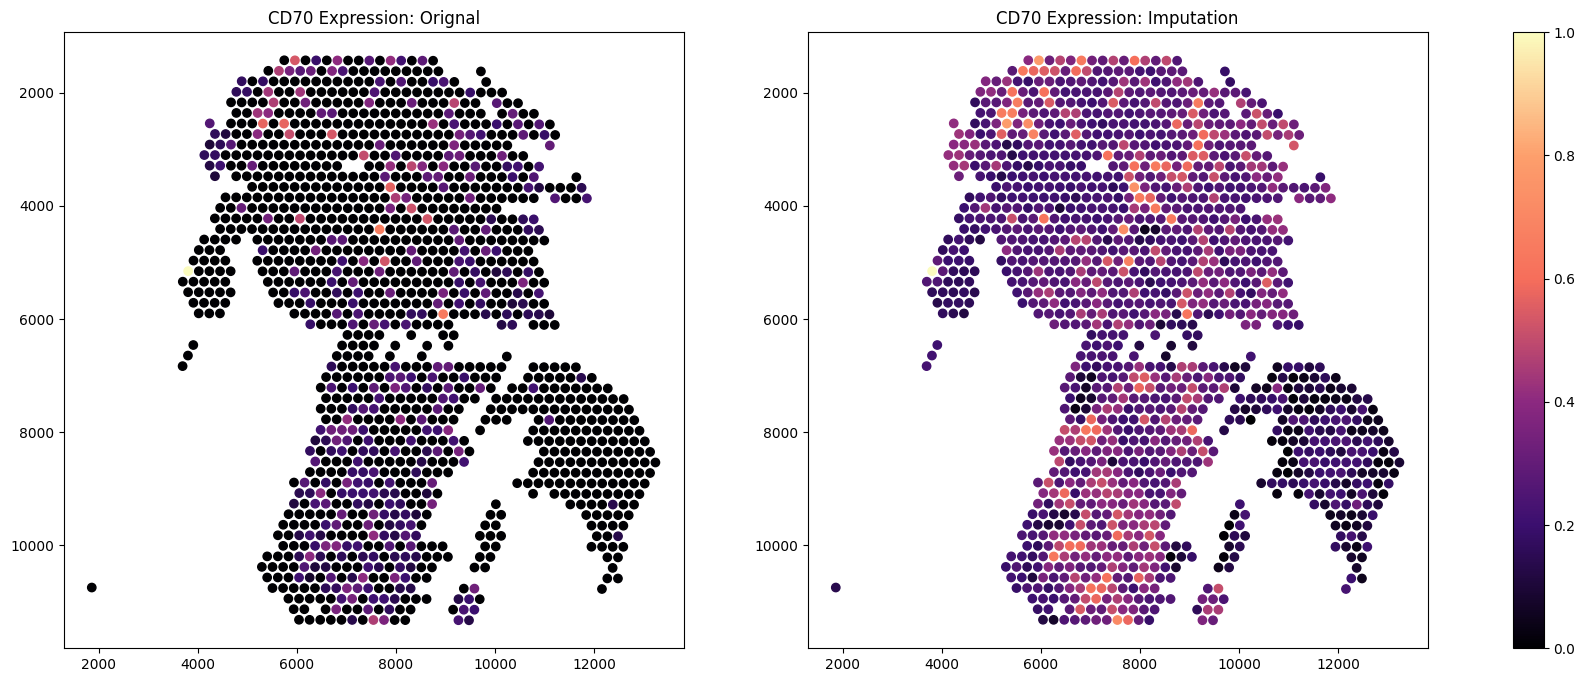

In [46]:
def plot_gene_data_scale(spatial_loc, genedata, title, ax):
    normalized_data = genedata
    normalized_data = (genedata - genedata.min()) / (genedata.max() - genedata.min())
    scatter = ax.scatter(spatial_loc[:,0], spatial_loc[:,1], c=normalized_data, cmap=cnt_color)   
    ax.invert_yaxis()
    ax.set_title(title)
    return scatter

##########################################################################################
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
gene = "CD70"  

# Orignal test data
orignal_matrix = pd.DataFrame(matrix_profile)
orignal_matrix.columns = gene_hv
genedata1 = orignal_matrix[[gene]].to_numpy()
scatter1 = plot_gene_data_scale(spatial_loc, genedata1, str(gene)+" Expression: Orignal", axes[0])

## Imputed test data
imputed_matrix_test_exp = pd.DataFrame(data_impt_reshape)
imputed_matrix_test_exp.columns = gene_hv
print(imputed_matrix_test_exp.shape)
genedata2 = imputed_matrix_test_exp[[gene]].to_numpy()
scatter2 = plot_gene_data_scale(spatial_loc, genedata2, str(gene)+" Expression: Imputation", axes[1])

# ## Reconstructed_f2 test data
# reconstruction_f2_reshape_pd = pd.DataFrame(recon_ref_adata_image_f2)
# reconstruction_f2_reshape_pd.columns = gene_hv
# print(reconstruction_f2_reshape_pd.shape)
# genedata3 = reconstruction_f2_reshape_pd[[gene]].to_numpy()
# scatter3 = plot_gene_data_scale(spatial_loc, genedata3, str(gene)+" Expression: Reconstructed F2", axes[2])

fig.colorbar(scatter1, ax=axes.ravel().tolist())
plt.show()

3.4 Correlation: selected gene

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = (5, 5)

def plot_correlation(genedata1, genedata2, ylabel, title, size):

    g = sns.JointGrid(x=genedata1[:, 0], y=genedata2[:, 0], space=0, height=size)
    g = g.plot_joint(sns.scatterplot, color="b")
    g = g.plot_marginals(sns.kdeplot, shade=True, color="b")

    pearson_corr, _ = pearsonr(genedata1[:, 0], genedata2[:, 0])
    cosine_sim = cosine_similarity(genedata1.reshape(1, -1), genedata2.reshape(1, -1))[0][0]

    lr = LinearRegression()
    lr.fit(genedata1, genedata2)
    x = np.array(g.ax_joint.get_xlim())
    y = lr.predict(x.reshape(-1, 1))
    g.ax_joint.plot(x, y[:, 0], color='red', linestyle='--')

    r2_value = r2_score(genedata2, lr.predict(genedata1))

    g.ax_joint.annotate(f'Pearson Correlation: {pearson_corr:.3f}\nCosine Similarity: {cosine_sim:.3f}\nR²: {r2_value:.3f}', 
                    xy=(0.4, 0.1), xycoords='axes fraction', fontsize=10)

    g.ax_joint.set_xlabel('Original Expression')
    g.ax_joint.set_ylabel(ylabel)
    g.fig.suptitle(title)

    plt.tight_layout()
    plt.show()

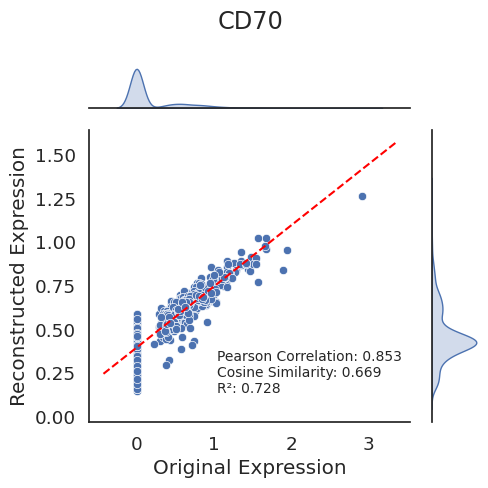

In [48]:
gene = "CD70"
title = "Predicted Expression"

genedata1 = orignal_matrix[[gene]].to_numpy()
genedata2 = imputed_matrix_test_exp[[gene]].to_numpy()

plot_correlation(genedata1, genedata2, 'Reconstructed Expression', gene, size=5)

3.5 Correlation: Spot

In [49]:
def calculate_statistics(matrix1, matrix2, label):
    print(matrix1.shape)
    print(matrix2.shape)

    ## pearson
    mean_pearson_corr = calculate_correlation_infer(matrix1, matrix2, method="pearson")
    logger.info(f'Mean Pearson correlation coefficient--{label}: {mean_pearson_corr}')

    ## spearman
    mean_spearman_corr = calculate_correlation_infer(matrix1, matrix2, method="spearman")
    logger.info(f'Mean Spearman correlation coefficient--{label}: {mean_spearman_corr}')

    ## cosine_similarity_row
    cosine_sim = calculate_cosine_similarity_row(matrix1, matrix2)
    cosine_sim_per_sample = np.diag(cosine_sim)
    average_cosine_similarity = np.mean(cosine_sim_per_sample)
    logger.info(f'Average cosine similarity--{label}: {average_cosine_similarity}')

## Correlation -- adata.shape[0] sample
logger.info("Running correlation task...")

## reconstructed by f2 (recon_ref_adata_image_f2)
calculate_statistics(matrix_profile, np.array(imputed_matrix_test_exp), 'reconf2')

logger.info("Running correlation task DINE!")

[2024-10-06 22:23:19] INFO - Running correlation task...


(1331, 596)
(1331, 596)


[2024-10-06 22:23:20] INFO - Mean Pearson correlation coefficient--reconf2: 0.8534651812923978
[2024-10-06 22:23:21] INFO - Mean Spearman correlation coefficient--reconf2: 0.6092512988048214
[2024-10-06 22:23:21] INFO - Average cosine similarity--reconf2: 0.8712951105022001
[2024-10-06 22:23:21] INFO - Running correlation task DINE!


3.6 Correlation: Gene

In [50]:
logger.info("Running Gene Correlation task...")

def calculate_statistics_gene(matrix1, matrix2, label):
    print(matrix1.shape)
    print(matrix2.shape)

    mean_pearson_corr = calculate_correlation_infer_gene(matrix1, matrix2, method="pearson")
    # print(f"Mean Pearson correlation coefficient--{label}: {mean_pearson_corr:.4f}")
    logger.info(f'Mean Pearson correlation coefficient--{label}: {mean_pearson_corr}')
    
    mean_spearman_corr = calculate_correlation_infer_gene(matrix1, matrix2, method="spearman")
    # print(f"Mean Spearman correlation coefficient--{label}: {mean_spearman_corr:.4f}")
    logger.info(f'Mean Spearman correlation coefficient--{label}: {mean_spearman_corr}')

    cosine_sim = calculate_cosine_similarity_col(matrix1, matrix2)
    cosine_sim_per_sample = np.diag(cosine_sim)
    average_cosine_similarity = np.mean(cosine_sim_per_sample)
    
    # print(f"Average cosine similarity--{label}: {average_cosine_similarity:.4f}")
    logger.info(f'Average cosine similarity--{label}: {average_cosine_similarity}')


## reconstructed by f2 
####################################
calculate_statistics_gene(matrix_profile, np.array(imputed_matrix_test_exp), 'reconf2')

logger.info("Running Gene Correlation task DINE!")

[2024-10-06 22:23:26] INFO - Running Gene Correlation task...
[2024-10-06 22:23:26] INFO - Mean Pearson correlation coefficient--reconf2: 0.8845136777311444


(1331, 596)
(1331, 596)


[2024-10-06 22:23:27] INFO - Mean Spearman correlation coefficient--reconf2: 0.5380078136125479
[2024-10-06 22:23:27] INFO - Average cosine similarity--reconf2: 0.6074921416885803
[2024-10-06 22:23:27] INFO - Running Gene Correlation task DINE!


3.7 Correlation: Spot and Gene 

0.8534651812923978
0.8845136777311444


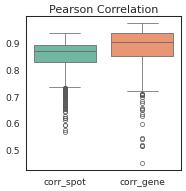

In [51]:
corr_spot = calculate_correlation_spot(matrix_profile, data_impt_reshape, method='pearson')
mean_corr_spot = np.mean(corr_spot)
corr_gene = calculate_correlation_gene(matrix_profile, data_impt_reshape, method='pearson')
## avoid nan
corr_gene = np.nan_to_num(corr_gene, nan=0.0)
mean_corr_gene = np.mean(corr_gene)

print(mean_corr_spot)
print(mean_corr_gene)

data = pd.DataFrame({
    'Type': np.concatenate([np.repeat('corr_spot', len(corr_spot)), np.repeat('corr_gene', len(corr_gene))]),
    'mean_corr': np.concatenate([corr_spot, corr_gene])
})


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14

plt.figure(figsize=(4, 4))
sns.boxplot(x='Type', y='mean_corr', data=data, palette='Set2')

plt.title('Pearson Correlation', fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)

ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)

plt.gcf().set_dpi(50)
# plt.savefig("NPC_PersonCor_spot_gene.pdf", format="pdf")
plt.show()

In [52]:
## save adata
# patientxy = 'patient1'
# adata_impt.write_h5ad(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata.h5ad')

In [132]:
print(orignal_matrix.shape)
print(imputed_matrix_test_exp.shape)
print(reconstruction_f2_reshape_pd_betwn.shape)

(1331, 596)
(1331, 596)
(3708, 596)


data_spot_pixel shape: (5039, 596)
cord_spot_pixel shape: (5039, 2)


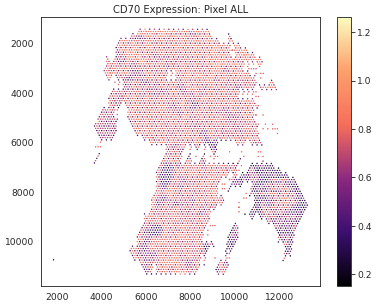

In [134]:
## add data in spot
data_spot_pixel = pd.concat([imputed_matrix_test_exp, reconstruction_f2_reshape_pd_betwn], axis=0, ignore_index=True)
print("data_spot_pixel shape:", data_spot_pixel.shape)

## add coord in pixel
cord_spot_pixel = pd.concat([pd.DataFrame(spatial_loc), pd.DataFrame(spatial_loc_add)], axis=0, ignore_index=False)
cord_spot_pixel.columns = ["x", "y"]
print("cord_spot_pixel shape:", cord_spot_pixel.shape)

## plot
gene = 'CD70'
fig, ax1 = plt.subplots(1, 1, figsize=(9, 7))
plot = ax1.scatter(cord_spot_pixel['x'], cord_spot_pixel['y'], c=data_spot_pixel[gene], cmap=cnt_color, s=1)   
ax1.set_title(str(gene) + ' Expression: Pixel ALL')
cbar = fig.colorbar(plot, ax=ax1)
ax1.invert_yaxis()
# plt.savefig(str(gene)+"P1_pixel.pdf", format="pdf")
plt.gcf().set_dpi(50)
plt.show()

## 4. Inference model for "within spot" and "between spot" 

4.1 Load trained model parameters

In [53]:
dir_name = str(path)+'FineST/FineST/Finetune/20240125140443830148'  
parameter_file_path = str(path)+'FineST/FineST/Parameter/parameters_NPC_P10125.json'

4.2 Load within spot & between spot image feature

In [54]:
#########################################
# Order to get 'position_order_all.csv'
#########################################

def process_file_paths(file_paths, filename):
    file_paths.sort()
    data = []
    for file_path in file_paths:
        parts = file_path.split('_')
        if filename == 'BRCAhuman':
            if file_path.startswith(str(filename)):
                data.append([int(parts[1]), int(parts[2].split('.')[0])])
            elif file_path.startswith('NEW'):
                data.append([parts[2], parts[3].split('.pth')[0]])
        elif filename == 'Patient1':
            if file_path.startswith('AH'):
                data.append([int(parts[2]), int(parts[3].split('.')[0])])
            elif file_path.startswith('NEW'):
                data.append([parts[3], parts[4].split('.pth')[0]])
    return data

#############################
# Get file paths
#############################
## add coords for each .pth file
file_paths_spot = os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/')
print(len(file_paths_spot))
file_paths_between_spot = os.listdir(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/NEW_AH_Patient1_pth_64_16/')
print(len(file_paths_between_spot))
## Merge, sort and process file paths
file_paths_all = file_paths_spot + file_paths_between_spot
print(len(file_paths_all))

#########################################################
# Merge, sort and process file paths
#########################################################
data_all = process_file_paths(file_paths_all, filename='Patient1')
df = pd.DataFrame(data_all, columns=['Part_3', 'Part_4'])
df = df.rename(columns={'Part_3': 'pixel_y', 'Part_4': 'pixel_x'})[['pixel_x', 'pixel_y']]
print(df)     

position_order_between_spot = pd.DataFrame({
    "pixel_y": df.loc[:, 'pixel_y'],
    "pixel_x": df.loc[:, 'pixel_x']
})

1331
3708
5039
     pixel_x pixel_y
0      10023   10014
1       9649   10015
2       9276   10016
3       7783   10020
4       7410   10021
...      ...     ...
5034  3023.5  9978.0
5035  2836.5  9978.5
5036  2650.0  9979.0
5037  2277.0  9980.0
5038  2090.5  9980.5

[5039 rows x 2 columns]


In [55]:
## save all spots
# position_order_between_spot.to_csv(str(path)+"FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv", index=False, header=False)

4.3 Load within & between spot gene expression data

In [56]:
def build_loaders_image_all(batch_size):

    setup_seed(666)
    
    print("***** Building loaders_inference between spot *****")
    import glob
    file_paths_spot = glob.glob(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/AH_Patient1_pth_64_16/*.pth')
    file_paths_between_spot = glob.glob(str(path) + 'NPC/Data/stdata/ZhuoLiang/LLYtest/NEW_AH_Patient1_pth_64_16/*.pth')
    image_paths = file_paths_spot + file_paths_between_spot
    image_paths.sort()
    
    dataset = DatasetCreatImageBetweenSpot(
        image_paths=image_paths,
        spatial_pos_path=str(path)+'FineST/FineST/Dataset/NPC/ContrastP1geneLR/position_order_all.csv',
    )
    
    all_dataset = DataLoader(dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
    print("***** Finished building loaders_inference between spot *****")
    return all_dataset

In [57]:
all_dataset = build_loaders_image_all(batch_size=len(file_paths_all))
print("all_dataset:\n", all_dataset)

input_image_all, input_coord_all = extract_test_data_image_between_spot(all_dataset)
print("input_image_all:", input_image_all.shape)
print("input_coord_all:", len(input_coord_all))
# print(input_image_all)
# print(input_coord_all)

***** Building loaders_inference between spot *****
Finished loading all files
***** Finished building loaders_inference between spot *****
all_dataset:


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

***** batch_size=adata.shape[0] *****
torch.Size([5039, 16, 384])
1
***** *****
Finished extractting image_between_spot data
input_image_all: torch.Size([5039, 16, 384])
input_coord_all: 1


4.4 Load the trained model to infer all spots

In [58]:
#####################################################################################  
# main
#####################################################################################

# load params
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)

# load models
model = load_model(dir_name, parameter_file_path, params, gene_hv)   
model.to(device)
# print("model", model)

## load between spots data
test_loader = build_loaders_image_all(batch_size=len(file_paths_all))

## inference
logger.info("Running inference tesk between spot...")

start_time = time.time()

(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = perform_inference_image_between_spot(model, test_loader)

print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
# print("recon_ref_adata_image_f2:\n", recon_ref_adata_image_f2)
# print("input_coord_all:\n", input_coord_all)

logger.info("Running inference tesk between spot DONE!")

***** Building loaders_inference between spot *****


[2024-10-06 22:24:34] INFO - Running inference tesk between spot...


Finished loading all files
***** Finished building loaders_inference between spot *****
device cuda:0
***** Begin perform_inference: ******


100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]
[2024-10-06 22:24:35] INFO - Running inference tesk between spot DONE!


***** batch_size=adata.shape[0] *****
torch.Size([5039, 16, 384])
1
***** *****
Finished extractting image_between_spot data
--- 0.28581905364990234 seconds ---
recon_ref_adata_image_f2: (5039, 596)


4.5 Visualization all spots

In [59]:
gene = "CD70"
## Reconstructed_f2 test data
reconstruction_f2_reshape_pd_all = pd.DataFrame(recon_ref_adata_image_f2)
reconstruction_f2_reshape_pd_all.columns = gene_hv
genedata3 = reconstruction_f2_reshape_pd_all[[gene]].to_numpy()
print(genedata3.shape)

reconstructed_matrix_test_arr = recon_ref_adata_image_f2.T
print(reconstructed_matrix_test_arr.shape)  

(5039, 1)
(596, 5039)


In [60]:
def process_and_check_duplicates(input_coord_all):
    
    tensor_1 = input_coord_all[0][0]
    tensor_2 = input_coord_all[0][1]

    input_coord_all_concat = torch.stack((tensor_1, tensor_2))
    spatial_loc = input_coord_all_concat.T.numpy()

    # Find unique rows and their counts
    unique_rows, counts = np.unique(spatial_loc, axis=0, return_counts=True)
    # Check if there are any duplicate rows
    duplicate_rows = (counts > 1).any()
    print("Are there any duplicate rows? :", duplicate_rows)
    return spatial_loc
    
spatial_loc_all = process_and_check_duplicates(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[10014.  10023. ]
 [10015.   9649. ]
 [10016.   9276. ]
 ...
 [ 9979.   2650. ]
 [ 9980.   2277. ]
 [ 9980.5  2090.5]]


genedata3:  (5039, 1)


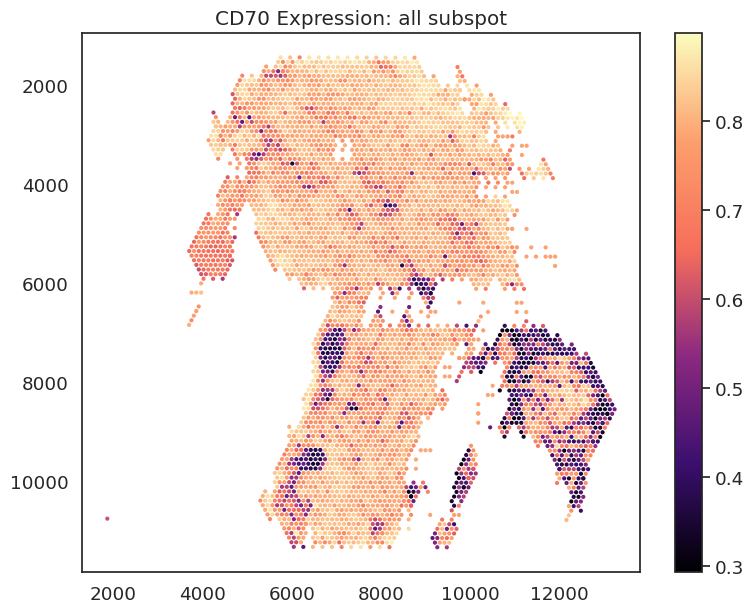

In [61]:
def plot_gene_data_dot(spatial_loc, genedata, title, ax):
    normalized_data = genedata
    # normalized_data = (genedata - genedata.min()) / (genedata.max() - genedata.min())
    scatter = ax.scatter(spatial_loc[:,0], spatial_loc[:,1], c=normalized_data, cmap=cnt_color, s=4)   
    ax.invert_yaxis()
    ax.set_title(title)
    return scatter

##########################################################################################
gene = "CD70"

fig, ax = plt.subplots(figsize=(9, 7))
genedata3 = reconstruction_f2_reshape_pd_all[[gene]].to_numpy()
print("genedata3: ", genedata3.shape)
scatter3 = plot_gene_data_dot(spatial_loc_all, genedata3, str(gene)+' Expression: all subspot', ax) 
fig.colorbar(scatter3, ax=ax)
plt.show()

4.6 Visualization all sub-spots

In [62]:
print(reconstructed_matrix_reshaped.shape)
print(reconstructed_matrix_reshaped.shape[0]/16)
reconstructed_matrix_reshaped_tensor, _ = reshape_latent_image(reconstructed_matrix_reshaped)
print(reconstructed_matrix_reshaped_tensor.shape)


################################################################################################
# Given a gene name, find the column index of the gene in the DataFrame
################################################################################################
gene = 'CD70'
column_index = matrix.columns.get_loc(gene)
column_index


def calculate_coordinates(spot_index, N, x, y):
    ## used for all subspot: torch.Size([19732, 16, 1543])
    C = np.zeros((N**2, 2), dtype=int)
    for k in range(1, N**2 + 1):
        s = k % N
        if s == 0:
            i = N
            j = k // N
        else:
            i = s
            j = (k - i) // N + 1
        C[k - 1, 0] = x - 8 - 1 * 16 + (i - 1) * 16
        C[k - 1, 1] = y - 8 - 1 * 16 + (j - 1) * 16

        ## 224
        # C[k - 1, 0] = x - 7 - 7 * 14 + (i - 1) * 14
        # C[k - 1, 1] = y - 7 - 7 * 14 + (j - 1) * 14
        ## 64  -- h=64/4=16 --  x-(h/2) - (4/2-1)*h
        C[k - 1, 0] = x - 8 - 1 * 16 + (i - 1) * 16
        C[k - 1, 1] = y - 8 - 1 * 16 + (j - 1) * 16
    return C


num_variables = int(reconstructed_matrix_reshaped.shape[0]/16)
num_coordinates = int(reconstructed_matrix_reshaped.shape[0])
all_spot_all_variable = np.zeros((num_variables, 16))
C2 = np.zeros((num_coordinates, 2), dtype=int)


NN = reconstructed_matrix_reshaped_tensor.shape[1]
N = int(np.sqrt(NN))

for p in range(num_variables):
    spot_first_variable = reconstructed_matrix_reshaped_tensor[p, :, column_index].cpu().detach().numpy()
    all_spot_all_variable[p, :] = spot_first_variable

    x = spatial_loc_all[p][0]
    y = spatial_loc_all[p][1]
    C = calculate_coordinates(p, N, x, y)

    C2[p * 16:(p + 1) * 16, :] = C

print(C2.shape)
print(C2)

torch.Size([80624, 596])
5039.0
torch.Size([5039, 16, 596])
(80624, 2)
[[ 9990  9999]
 [10006  9999]
 [10022  9999]
 ...
 [ 9972  2114]
 [ 9988  2114]
 [10004  2114]]


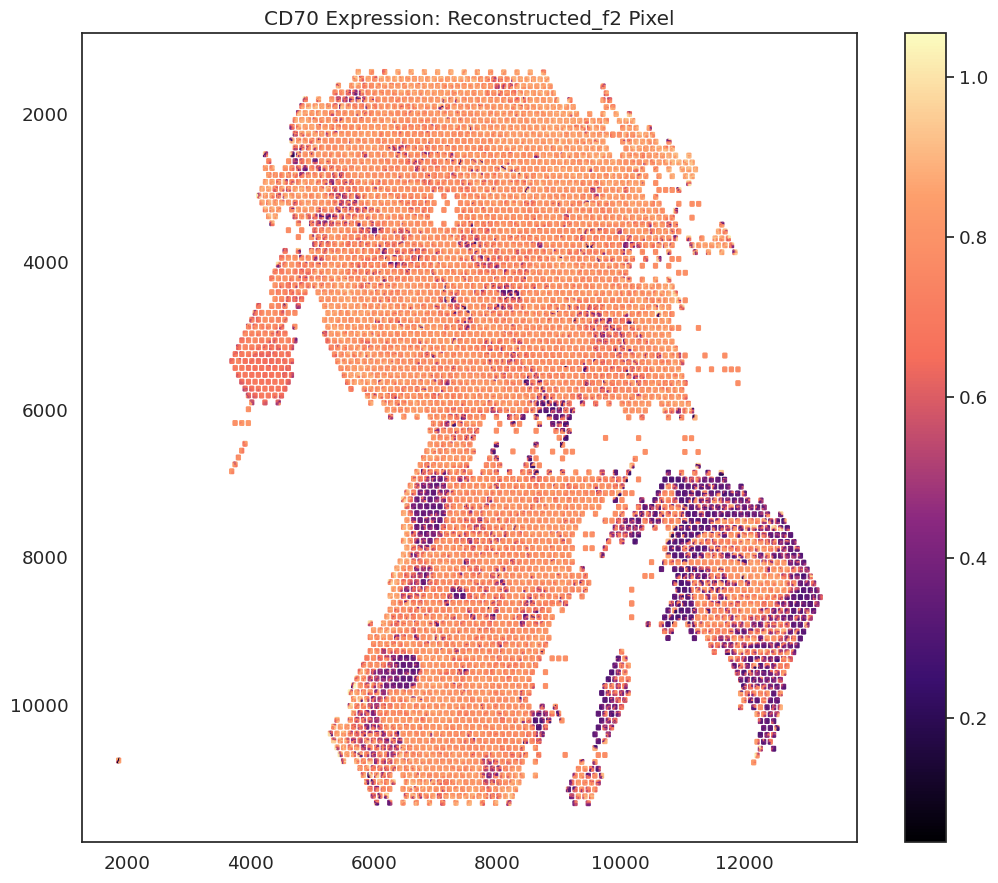

In [63]:
fig, ax1 = plt.subplots(1, 1, figsize=(12.5, 10.5))
plot = ax1.scatter(C2[:, 0], C2[:, 1], c=all_spot_all_variable.flatten(), cmap=cnt_color, s=0.5)
ax1.set_title(str(gene) + ' Expression: Reconstructed_f2 Pixel')
cbar = fig.colorbar(plot, ax=ax1)
ax1.invert_yaxis()
# plt.savefig("P1_pixel.pdf", format="pdf")
plt.gcf().set_dpi(100)
plt.show()

4.7 All subspt location

In [64]:
print(reconstructed_matrix_reshaped_tensor.shape)
print(reconstructed_matrix_reshaped_tensor[0, :, :].shape)
print(reconstructed_matrix_reshaped_tensor[:, :, 0].flatten().shape)

torch.Size([5039, 16, 596])
torch.Size([16, 596])
torch.Size([80624])


In [65]:
# Initialize variables all_spot_all_variable and C2
all_spot_all_variable_all = np.zeros((reconstructed_matrix_reshaped_tensor.shape[0]*reconstructed_matrix_reshaped_tensor.shape[1], 
                                      reconstructed_matrix_reshaped_tensor.shape[2]))

# get the sub-spot gene expression
for q in range(reconstructed_matrix_reshaped_tensor.shape[2]):
    # Extract the information of the first variable of the pth spot
    all_spot_all_variable_all[:, q] = reconstructed_matrix_reshaped_tensor[:, :, q].flatten().cpu().detach().numpy()    # the first variable
print(all_spot_all_variable_all.shape)

# Create AnnData object
adata_spot_all = sc.AnnData(X=pd.DataFrame(all_spot_all_variable_all))
adata_spot_all.var_names = gene_hv
adata_spot_all.obs["x"], adata_spot_all.obs["y"] = C2[:, 0], C2[:, 1]

print(adata_spot_all)
# print(adata_spot_all.obs["x"])
# print(adata_spot_all.var_names)

(80624, 596)
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'


0        0.554325
1        0.534475
2        0.505098
3        0.664154
4        0.570816
           ...   
80619    0.870487
80620    0.848460
80621    0.910438
80622    0.874521
80623    0.834541
Name: CD70, Length: 80624, dtype: float64


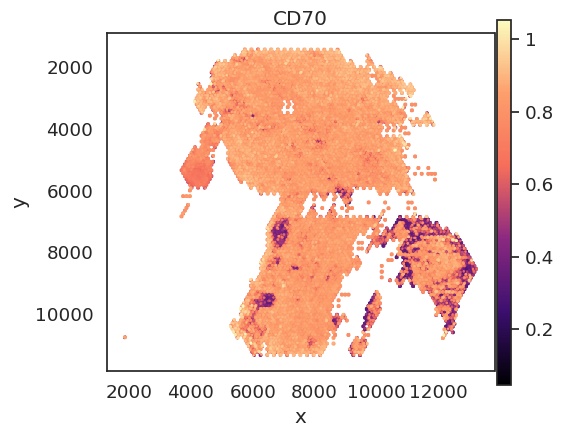

In [66]:
gene = "CD70"

adata_spot_all.obs[gene]=adata_spot_all.X[:,adata_spot_all.var.index==gene]
print(adata_spot_all.obs[gene])
fig=sc.pl.scatter(adata_spot_all,alpha=1,x="x",y="y",color=gene,color_map=cnt_color,show=False,size=10) 
fig.set_aspect('equal', 'box')
fig.invert_yaxis()
plt.gcf().set_dpi(100)
fig.figure.show()

## 5. Imputation using measured spot expressiom

5.1 Neighbours of all within spot

In [67]:
def prepare_adata(adata, adata_spot, C2, gene_hv):
    # adata_know: adata (original) 1331 × 596
    # adata_spot: all subspot 21296 × 596
    adata_know = adata.copy()
    adata_know.obs["x"]=adata.obsm['spatial'][:,0]
    adata_know.obs["y"]=adata.obsm['spatial'][:,1]

    x_sudo, y_sudo = adata_spot.obs["x"].values, adata_spot.obs["y"].values
    x_know, y_know = adata_know.obs["x"].values, adata_know.obs["y"].values
    print("X_sudo & x_know:", x_sudo.shape, x_know.shape)    # X_sudo & x_know: (17424,) (adata.shape[0],)

    adata_spot.obsm['spatial'] = np.stack([adata_spot.obs["x"], adata_spot.obs["y"]]).T

    xlist = C2[:, 0].tolist()
    ylist = C2[:, 1].tolist()
    sudo = pd.DataFrame({"x": xlist, "y": ylist})  

    sudo_adata = anndata.AnnData(np.zeros((sudo.shape[0], len(gene_hv))))
    sudo_adata.obs = sudo
    sudo_adata.var = adata_know.var
    
    return adata_know, sudo_adata, adata_spot

In [68]:
adata_know, sudo_adata_all, adata_spot_all = prepare_adata(adata, adata_spot_all, C2, gene_hv)
print(sudo_adata_all)

X_sudo & x_know: (80624,) (1331,)
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [69]:
nearest_points = find_nearest_point(adata_spot_all.obsm['spatial'], adata_know.obsm['spatial'])    
nbs, nbs_indices = find_nearest_neighbors(nearest_points, adata_know.obsm['spatial'])
distances = calculate_euclidean_distances(adata_spot_all.obsm['spatial'], nbs)

## Iterate over each point in sudo_adata_all
start_time = time.time()
for i in range(sudo_adata_all.shape[0]):
    dis_tmp = (distances[i] + 0.1) / np.min(distances[i] + 0.1)
    k = 1
    weights = ((1 / (dis_tmp ** k)) / ((1 / (dis_tmp ** k)).sum()))
    sudo_adata_all.X[i, :] = np.dot(weights, adata_know.X[nbs_indices[i]].todense())

print("--- %s seconds ---" % (time.time() - start_time))

--- 12.08984088897705 seconds ---


In [70]:
print(adata.X.A)
print(adata_spot_all.X)
print(sudo_adata_all.X)

[[0.         0.         0.         ... 1.4639113  0.         0.        ]
 [1.5438051  0.90541154 0.90541154 ... 0.90541154 1.5438051  0.551857  ]
 [0.         0.         1.0923328  ... 0.         0.         0.        ]
 ...
 [0.68265146 0.         0.         ... 0.68265146 1.0845934  1.0845934 ]
 [0.         0.         0.         ... 0.         1.2505107  0.        ]
 [0.6407335  0.         0.         ... 0.         1.3066062  0.        ]]
[[1.31799281 0.56362665 1.01991451 ... 1.09909415 2.46734881 1.40222216]
 [1.33040011 0.56309283 1.04158568 ... 1.099581   2.4346807  1.40167749]
 [1.32670617 0.55537564 1.05652225 ... 1.08821797 2.3501575  1.38864398]
 ...
 [1.28910756 0.64031994 0.81899369 ... 1.16513872 3.26231074 1.47897673]
 [1.30654907 0.62080795 0.8467086  ... 1.16910458 3.15758348 1.46908164]
 [1.28763533 0.59709299 0.85100269 ... 1.1526233  3.03158903 1.43560588]]
[[0.19212073 0.14295181 0.21724944 ... 0.92930197 0.16669527 0.22734294]
 [0.16373539 0.11892636 0.17475145 ... 

In [71]:
## save two adata
# patientxy = 'Patient1'
# adata_spot_all.write_h5ad(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_adata_spot_all.h5ad')
# sudo_adata_all.write_h5ad(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/'+str(patientxy)+'_sudo_adata_all.h5ad')

In [72]:
## Load two data
# patientxy = 'Patient1'
# os.chdir(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/')
# adata_spot_all = sc.read_h5ad(filename=str(patientxy)+'_adata_spot_all.h5ad')
# sudo_adata_all = sc.read_h5ad(filename=str(patientxy)+'_sudo_adata_all.h5ad')

5.2 Add inference and impution data

In [73]:
print(sudo_adata_all)
print(adata_spot_all)
# print(sudo_adata_all.obs['x'])
# print(adata_spot_all.obs['x'])

# using the weight and add
w1 = 0.5
weight_impt_data_all = w1*adata_spot_all.X + (1-w1)*sudo_adata_all.X
adata_impt_all = sc.AnnData(X = pd.DataFrame(weight_impt_data_all))

adata_impt_all.var_names = gene_hv
adata_impt_all.obs = adata_spot_all.obs
# print("adata_impt_all: ", adata_impt_all)
# print(adata_impt_all.obs['x'])

AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y', 'CD70'
    obsm: 'spatial'


In [74]:
weight_impt_data_all_tensor = torch.tensor(weight_impt_data_all)
print(weight_impt_data_all_tensor.shape)
print(weight_impt_data_all_tensor[:10])

_, adata_impt_all_reshape = reshape_latent_image(weight_impt_data_all_tensor)
print(adata_impt_all_reshape.shape)
print(adata_impt_all_reshape[:10])

torch.Size([80624, 596])
tensor([[0.7551, 0.3533, 0.6186,  ..., 1.0142, 1.3170, 0.8148],
        [0.7471, 0.3410, 0.6082,  ..., 1.0618, 1.2832, 0.7946],
        [0.7457, 0.3359, 0.6114,  ..., 1.0620, 1.2369, 0.7854],
        ...,
        [0.7225, 0.3455, 0.5528,  ..., 1.0732, 1.3578, 0.7880],
        [0.6908, 0.3626, 0.4906,  ..., 1.0599, 1.5304, 0.7918],
        [0.6603, 0.3263, 0.4673,  ..., 1.1522, 1.4382, 0.7454]],
       dtype=torch.float64)
torch.Size([5039, 596])
tensor([[0.7114, 0.3459, 0.5409,  ..., 1.0766, 1.3782, 0.7821],
        [1.1502, 0.6222, 0.7276,  ..., 0.9088, 1.9652, 0.9071],
        [0.6043, 0.3282, 0.7858,  ..., 0.5805, 1.4134, 0.6444],
        ...,
        [0.7713, 0.4575, 0.5606,  ..., 0.9314, 2.1450, 1.0506],
        [0.9161, 0.4793, 0.4842,  ..., 0.8907, 1.7709, 0.9171],
        [0.7137, 0.3250, 0.8277,  ..., 0.8162, 1.6566, 0.7935]],
       dtype=torch.float64)


5.3 save the imputation spot data

In [75]:
adata_impt_spot = sc.AnnData(X = pd.DataFrame(adata_impt_all_reshape.cpu().detach().numpy()))
adata_impt_spot.var_names = gene_hv
adata_impt_spot.obs['x'] = spatial_loc_all[:,0]
adata_impt_spot.obs['y'] = spatial_loc_all[:,1]

print("adata_impt_spot: ", adata_impt_spot)
print(adata_impt_spot.obs['x'])

adata_impt_spot:  AnnData object with n_obs × n_vars = 5039 × 596
    obs: 'x', 'y'
0       10014.0
1       10015.0
2       10016.0
3       10020.0
4       10021.0
         ...   
5034     9978.0
5035     9978.5
5036     9979.0
5037     9980.0
5038     9980.5
Name: x, Length: 5039, dtype: float64


In [76]:
## save data: 5039 × 596
# patientxy = 'patient1'
# os.chdir(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/')
# adata_impt_spot.write_h5ad(filename=str(patientxy)+'_adata_all_spot.h5ad')

5.4 Visualization: gene at all spot

genedata2: (5039, 1)


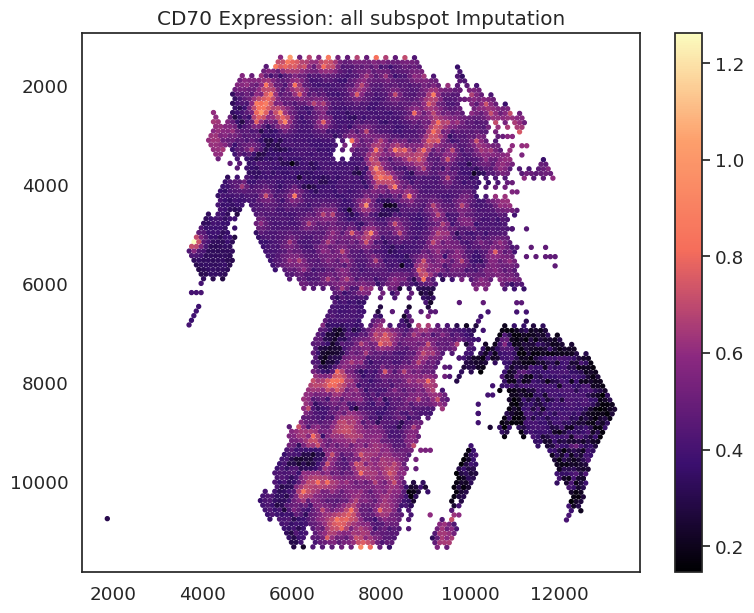

In [77]:
def plot_gene_data_single(spatial_loc, genedata, title, ax):
    normalized_data = genedata
    # normalized_data = (genedata - genedata.min()) / (genedata.max() - genedata.min())
    scatter = ax.scatter(spatial_loc[:,0], spatial_loc[:,1], c=normalized_data, cmap=cnt_color, s=8)    
    ax.invert_yaxis()
    ax.set_title(title)
    return scatter

#################################################################################################################
gene = "CD70"

## Imputed all subspot data
imputed_matrix_test_exp_all = pd.DataFrame(adata_impt_all_reshape)
imputed_matrix_test_exp_all.columns = gene_hv
genedata2 = imputed_matrix_test_exp_all[[gene]].to_numpy()
print("genedata2:", genedata2.shape)
fig, ax = plt.subplots(figsize=(9, 7))
scatter2 = plot_gene_data_single(spatial_loc_all, genedata2, str(gene)+" Expression: all subspot Imputation",  ax)
fig.colorbar(scatter2, ax=ax)

plt.gcf().set_dpi(100)
# plt.savefig(str(gene)+"_Expression_Imputation_allsubspot.pdf", format="pdf")

plt.show()

5.5 Visualization: gene at all sub-spot

0        0.277162
1        0.267238
2        0.252549
3        0.332077
4        0.285408
           ...   
80619    0.581720
80620    0.564013
80621    0.603303
80622    0.593764
80623    0.581188
Name: CD70, Length: 80624, dtype: float64


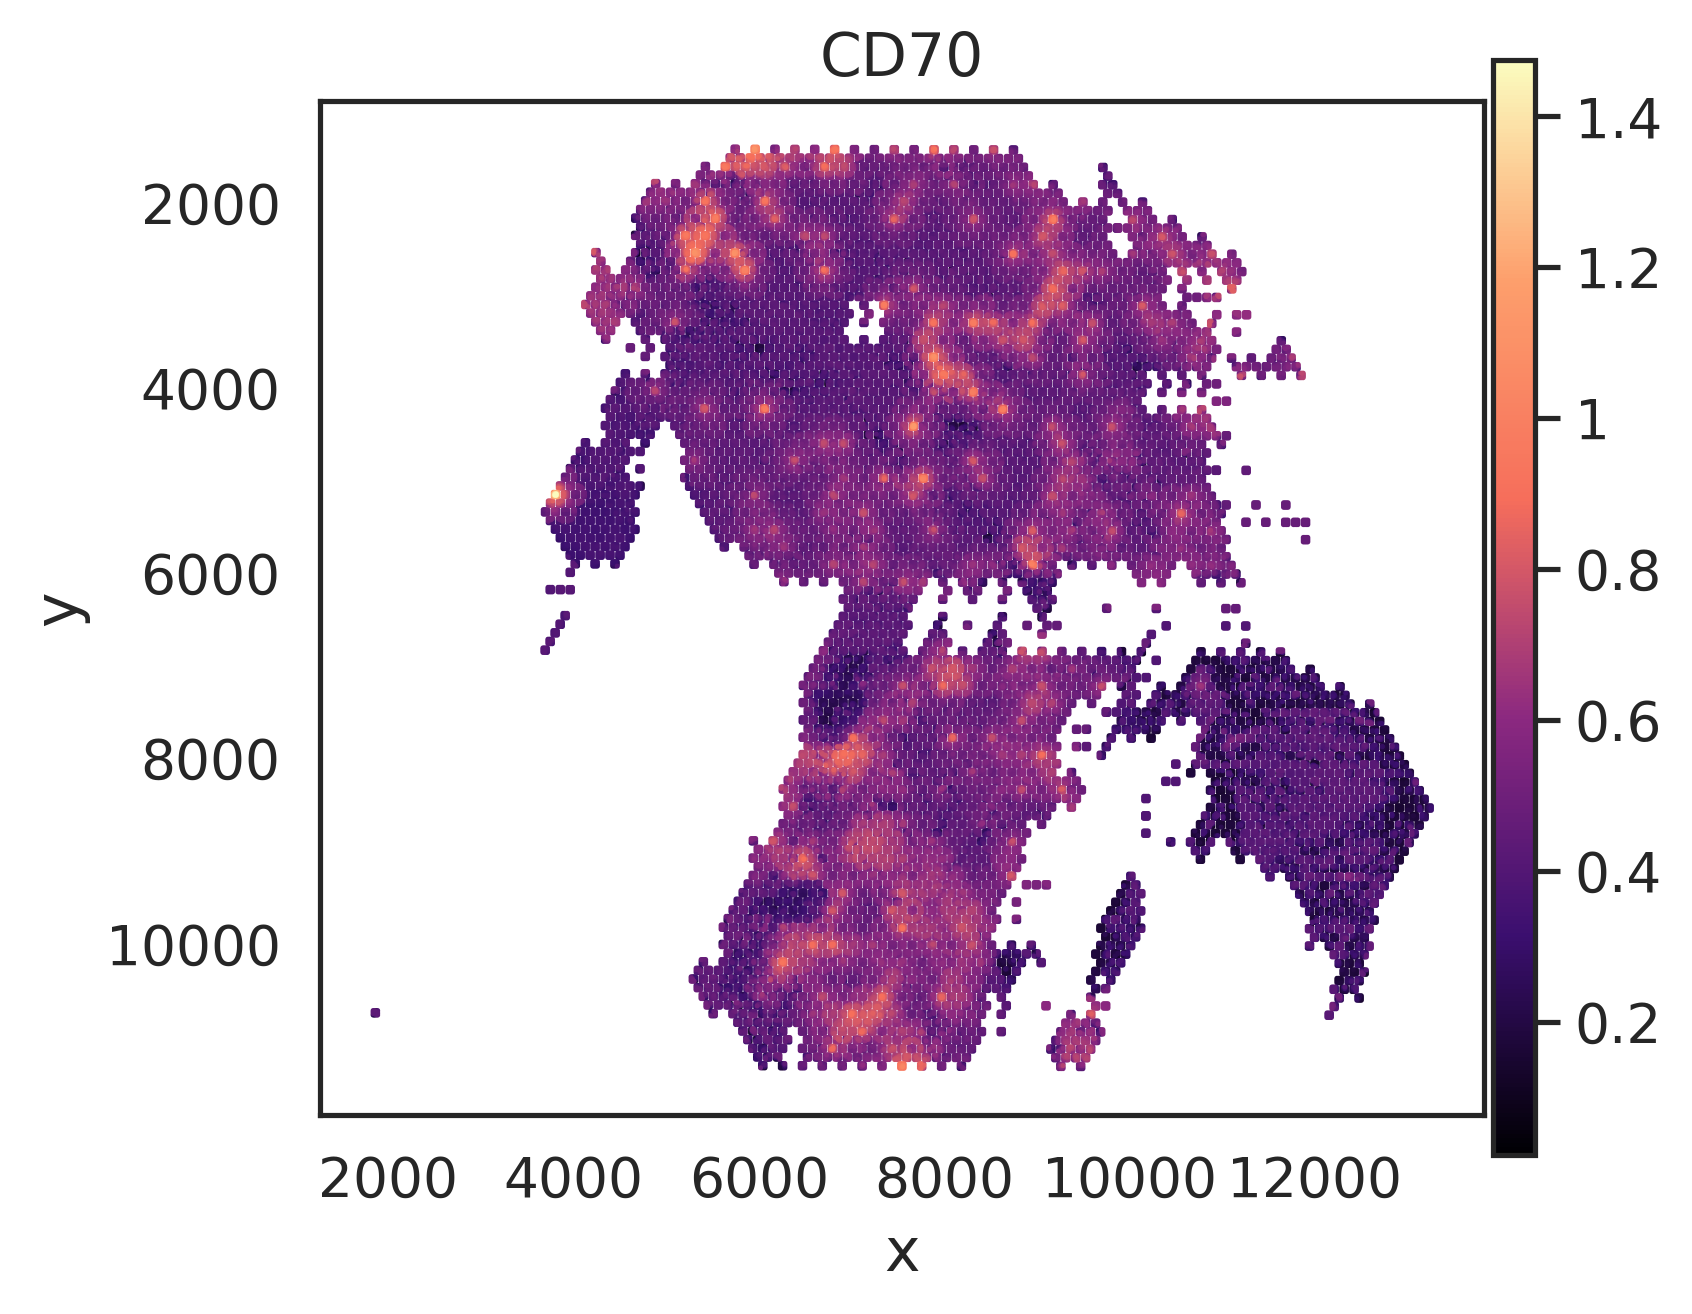

In [89]:
gene = "CD70"

adata_spot_all.obs[gene]=adata_impt_all.X[:,adata_impt_all.var.index==gene]
print(adata_spot_all.obs[gene])
fig=sc.pl.scatter(adata_impt_all,alpha=1,x="x",y="y",color=gene,color_map=cnt_color,show=False,size=6) 
fig.set_aspect('equal', 'box')
fig.invert_yaxis()
plt.gcf().set_dpi(300)
fig.figure.show()

##  6. Save all subspot imupted data

In [78]:
print(adata_impt_all)

AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y', 'CD70'


In [87]:
## save adata: 80624 × 596
# patientxy = 'patient1'
# os.chdir(str(path)+'FineST/FineST/Dataset/ImputData/'+str(patientxy)+'/')
# adata_impt_all.write_h5ad(filename=str(patientxy)+'_adata_all.h5ad')

In [88]:
## End